# Проект "Информационная безопасность"

Компания онлайн-сервис с высоким уровнем входящего трафика имеет специализированный отдел безопасности, который занимается фильтрацией и анализом трафика. Сотрудники этого отдела обратились за помощью в автоматизации выявления аномального и злонамеренного трафика.

## Цель проекта:
Разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный, включая следующие типы атак: DDoS, SQL-инъекции, брутфорс, вредоносные программы и т.д.
## План работы:
- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков.

# 1. Предварительный анализ данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

#from lightgbm import LGBMRegressor

#from catboost import CatBoostClassifier
from sklearn.metrics import classification_report


In [2]:
# Загрузим наши данные
df=pd.read_csv('/content/network_traffic_data.csv')

In [3]:
# создадим функцию для первоначального анализа данных
def df_info(dataframe):
    column = dataframe.columns.values.tolist() # список наименований столбцов таблицы
    print('Общая информация о таблице:\n')
    dataframe.info() # общая информация о таблице
    print('\nВнешний вид таблицы :')
    display(dataframe.sample(5)) # внешний вид первых 5 строк таблицы

    # далее выводим все интересующие нас особенности таблицы, соответствнно, обозначенные в функции print()
    print('Столбцы таблицы: {}\n'.format(column),
          '\n\nОбщее количество уникальных значений столбцов {}:\n\n{}'.
          format(column, dataframe.nunique()),
          '\n\nКоличество пропущенных значений столбцов {}:\n\n{}'.
          format(column, dataframe.isna().sum()))



In [4]:
df_info(df)

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             539616 non-null  int64  
 1    Flow Duration                539616 non-null  int64  
 2    Total Fwd Packets            539616 non-null  int64  
 3    Total Backward Packets       539616 non-null  int64  
 4   Total Length of Fwd Packets   539616 non-null  int64  
 5    Total Length of Bwd Packets  539616 non-null  int64  
 6    Fwd Packet Length Max        539616 non-null  int64  
 7    Fwd Packet Length Min        539616 non-null  int64  
 8    Fwd Packet Length Mean       539616 non-null  float64
 9    Fwd Packet Length Std        539616 non-null  float64
 10  Bwd Packet Length Max         539616 non-null  int64  
 11   Bwd Packet Length Min        539616 non-null  int64  
 12   Bwd Packet Len

Destination Port   Flow Duration   Total Fwd Packets  \
328970                 80        99513737                   6   
37142                  53           30443                   1   
373810                 80        98321793                   7   
226276                443          663368                   7   
142698                 80        98522006                  15   

         Total Backward Packets  Total Length of Fwd Packets  \
328970                        6                          307   
37142                         1                           44   
373810                        7                          385   
226276                       10                          854   
142698                       14                          932   

         Total Length of Bwd Packets   Fwd Packet Length Max  \
328970                         11595                     307   
37142                             60                      44   
373810                         11595                     361   
226276                          4000                     508   
142698                          3552                     430   

         Fwd Packet Length Min   Fwd Packet Length Mean  \
328970                       0                    51.16   
37142                       44                    44.00   
373810                       0                    55.00   
226276                       0                   122.00   
142698                       0                    62.12   

         Fwd Packet Length Std  ...   min_seg_size_forward  Active Mean  \
328970                   125.3  ...                     32         4.00   
37142                      0.0  ...                     20         0.00   
373810                   135.0  ...                     20     13008.00   
226276                   187.4  ...                     20         0.00   
142698                   149.4  ...                     20    427741.88   

         Active Std   Active Max   Active Min   Idle Mean   Idle Std  \
328970          0.0            4            4  99400000.0      0.000   
37142           0.0            0            0         0.0      0.000   
373810          0.0        13008        13008  98300000.0      0.000   
226276          0.0            0            0         0.0      0.000   
142698    1213957.1      3664961        22876   9994610.0   7537.102   

         Idle Max   Idle Min     Label  
328970   99400000   99400000  DoS Hulk  
37142           0          0    BENIGN  
373810   98300000   98300000  DoS Hulk  
226276          0          0    BENIGN  
142698   10000000    9979705    BENIGN  

[5 rows x 79 columns]

Столбцы таблицы: [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Co

In [3]:
# Приведем все к РЕР-8
df.columns = (df.columns
                        .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                        .str.replace(' ', '_')
                        .str.replace('/','_')
                        .str.replace('.', '_')
                        .str.lower()
                        .str.lstrip('_')
                        .str.rstrip(' '))

Мы привели названия к соответствующему РЕР-8 нормам, можем приступать к предварительному анализу. Теперь для экономии памяти, переведем тип данных в int/float32

In [4]:
#  Поменяем тип данных
for i in df.columns:
  if df[i].dtype=='int64':
      df[i]=df[i].astype('int32')
  elif df[i].dtype=='float64':
      df[i]=df[i].astype('float32')

# Проверим наши преобразования
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   destination_port             539616 non-null  int32  
 1   flow_duration                539616 non-null  int32  
 2   total_fwd_packets            539616 non-null  int32  
 3   total_backward_packets       539616 non-null  int32  
 4   total_length_of_fwd_packets  539616 non-null  int32  
 5   total_length_of_bwd_packets  539616 non-null  int32  
 6   fwd_packet_length_max        539616 non-null  int32  
 7   fwd_packet_length_min        539616 non-null  int32  
 8   fwd_packet_length_mean       539616 non-null  float32
 9   fwd_packet_length_std        539616 non-null  float32
 10  bwd_packet_length_max        539616 non-null  int32  
 11  bwd_packet_length_min        539616 non-null  int32  
 12  bwd_packet_length_mean       539616 non-null  float32
 13 

In [7]:
# Выведем необходимую информацию по датасету
print('\033[94m  \033[1m {:^24s}'.format("Deep information"))
info_1 = pd.DataFrame(index=df.columns, columns=['rows'], data=len(df))
for col in df:
    if (pd.api.types.is_numeric_dtype(df[col])) and df[col].min() == 0:
        info_1.loc[col, "null_row"] = df.loc[df[col] == 0, col].count()
    else:
        info_1.loc[col, "null_row"] = 0
info_1["uniq"] = df.nunique()
info_1["dup_val"] = [df[i].duplicated().sum() for i in df]
info_1["dup_row"] = df.duplicated().sum()
info_1["NaN"] = df.isna().sum()
info_1["NaN,%"] = df.isna().sum() / 100
info_1["type"] = df.dtypes
info_1["inf_row"] = [df[i].isin([np.inf, -np.inf]).sum() for i in df]
info_1 = info_1.join(df.describe(include="number")["mean":].transpose())
info_1["null_row"] = pd.to_numeric(info_1["null_row"], downcast="integer")
info_1.fillna("", inplace=True)
prop = {
        "border": "0.5px solid black",
        "width": "85px",
        "text-align": "center"
    }
percent = {
        "NaN,%":"{:.2%}",
        "mean":"{:.3}",
        "std":"{:.3}",
        "min":"{:.3}",
        "25%":"{:.3}",
        "50%":"{:.3}",
        "75%":"{:.3}",
        "max":"{:.3}",
    }

display(info_1.style.format(percent).set_properties(**prop))

       Deep information    


Видим, что у признака 'Flow Bytes/s' есть пропущенные значения. Как вариант, можем их удалить, или заполнить нулем. Также, в стобцах 'Flow Packets/s' и  'Flow Bytes/s' присутствуют бесконечные величины. Их мы заменим на максимальные значения в этих столбцах.

Есть признаки, которые имеют большое кол-во нулевых показателей, также имеем и отрицательные значения. Удалять их пока не будем, но если это повлияет на метрику, то удалим нулевые значения, потом и отрицательные.

Самих признаков очень много. Можно попытаться просмотреть по корреляции, какие признаки убрать.

In [5]:
# Начнем с замены бесконечных значений
max_value_flow_bytes_s = np.nanmax(df['flow_bytes_s'][df['flow_bytes_s'] != np.inf ])
df['flow_bytes_s'].replace([np.inf , -np.inf ], max_value_flow_bytes_s, inplace= True )

max_value_flow_packets_s = np.nanmax(df['flow_packets_s'][df['flow_packets_s'] != np.inf ])
df['flow_packets_s'].replace([np.inf , -np.inf ], max_value_flow_packets_s, inplace= True )

# Проверим нашу замену
inf_values= df.isin([np.inf, -np.inf]).values.sum()
inf_values

0

In [6]:
# Посмотрим оставшиеся пропуски в 'flow_bytes_s'
df['flow_bytes_s'].isna().sum()

488

In [7]:
# попробуем заменить пропуски на среднее
df['flow_bytes_s']= df['flow_bytes_s'].fillna(df['flow_bytes_s'].mean())
df['flow_bytes_s'].isna().sum()

0

Теперь проверим наш целевой признак. Как мы поняли из общей информации, это единственный категориальный признак в нашем датасете.

BENIGN                        240000
DoS Hulk                      115974
PortScan                       79660
DDoS                           64366
DoS GoldenEye                  10293
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: label, dtype: int64



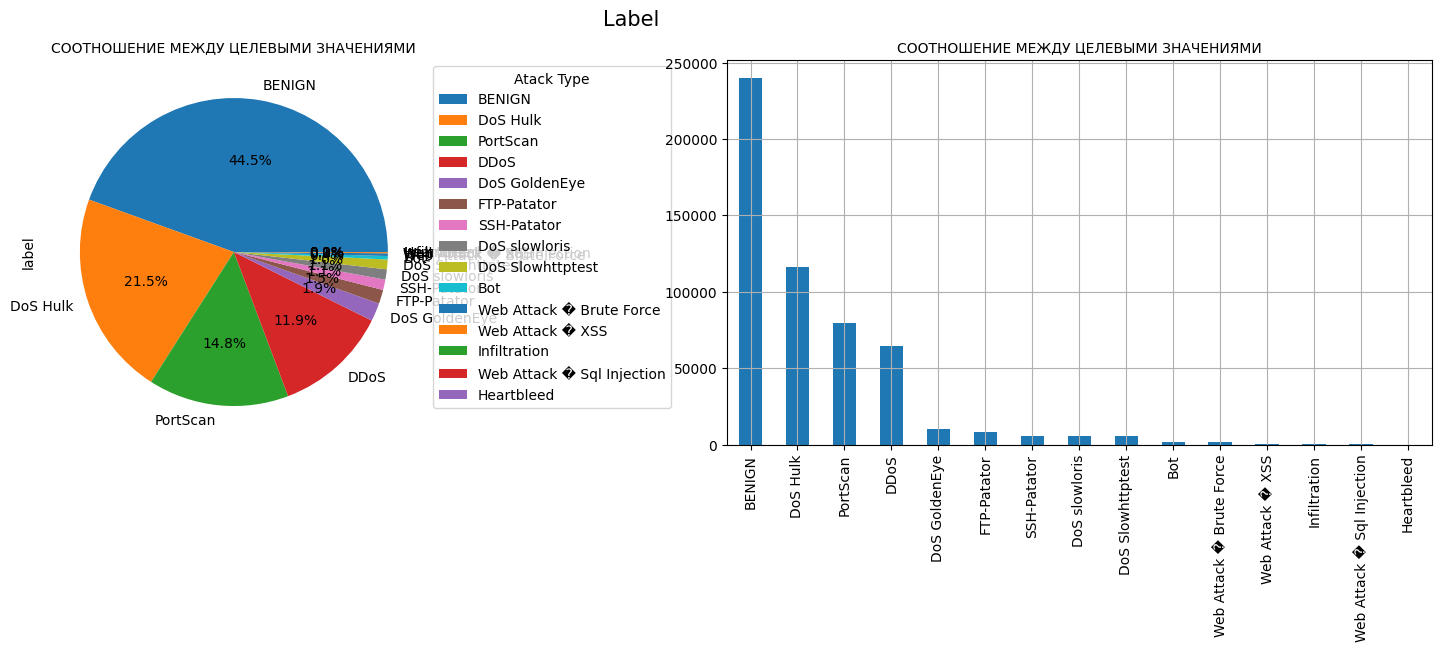

In [11]:
# Посмотрим признак 'label'

df_value=df['label'].value_counts()
print(df_value)
print()

plt.figure(figsize=(23, 10))
plt.suptitle('Label', fontsize=15)

plt.subplot(1, 2, 1)
df_value.plot(kind='pie', autopct='%1.1f%%')
plt.legend(title ="Atack Type",
           loc ="best",
          bbox_to_anchor =(1, 0, 0.5, 1))
plt.title('СООТНОШЕНИЕ МЕЖДУ ЦЕЛЕВЫМИ ЗНАЧЕНИЯМИ', size=10)

plt.subplot(1, 2, 2)
plt.title('СООТНОШЕНИЕ МЕЖДУ ЦЕЛЕВЫМИ ЗНАЧЕНИЯМИ', fontsize=10)
df_value.plot(kind='bar', figsize=(20,5))
plt.grid(True)

plt.show()

Перед нами представлены 15 различных видов "атак". Нам известно, что только один из них- BENIGN -является невредоностным. Далее нам необходимо перевести эти категориальные признаки в 15 классов (числовые признаки от 0 до 14). Воспользуемся методикой LabelEncoder. Ну и придется сделать масштабирование,  так как наблюдается явный дисбаланс.

Посмотрим на корреляцию.

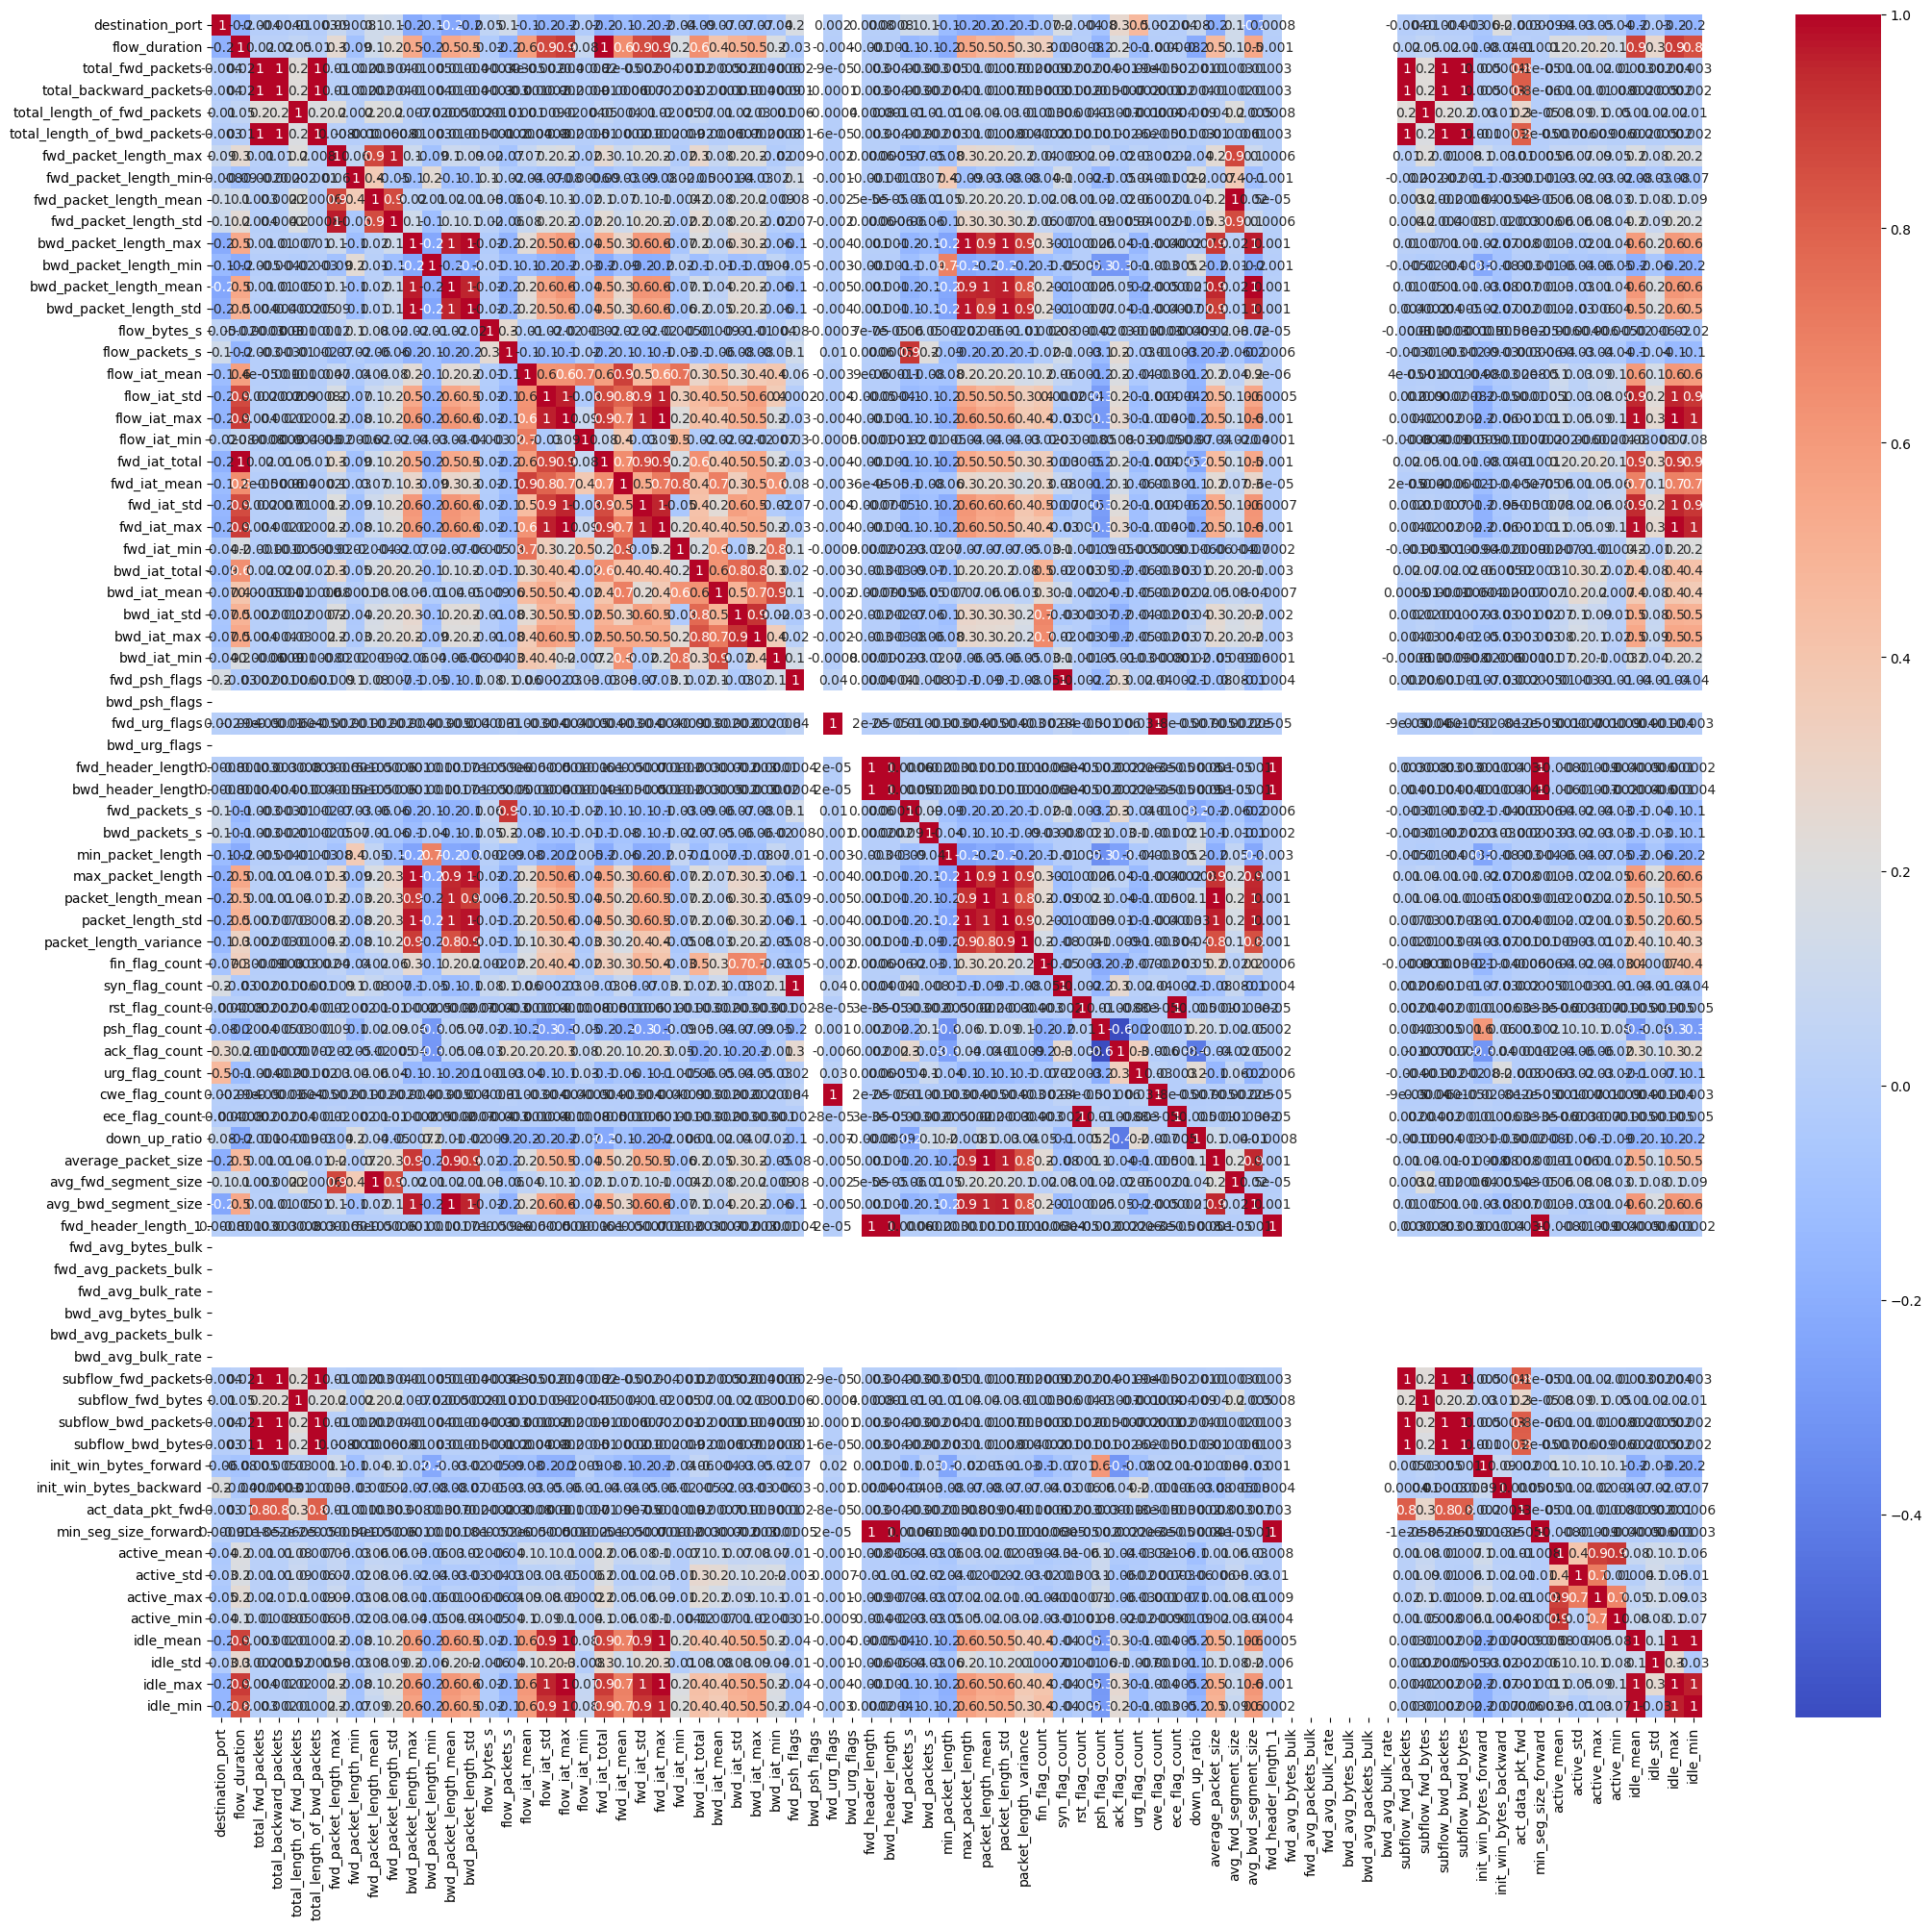

In [12]:
# Посмотрим на корреляцию признаков
corr = df.corr()
plt.figure(figsize= (25, 23))
sns.heatmap(corr,cmap= 'coolwarm', fmt=".1g", annot=True)
plt.show()

In [8]:
# Удалим признак с нулевой корреляцией
df_filtred=df.drop(columns=['bwd_psh_flags', 'bwd_urg_flags', 'fwd_avg_bytes_bulk', 'fwd_avg_packets_bulk',
                                'fwd_avg_bulk_rate', 'bwd_avg_bytes_bulk', 'bwd_avg_packets_bulk','bwd_avg_bulk_rate'])


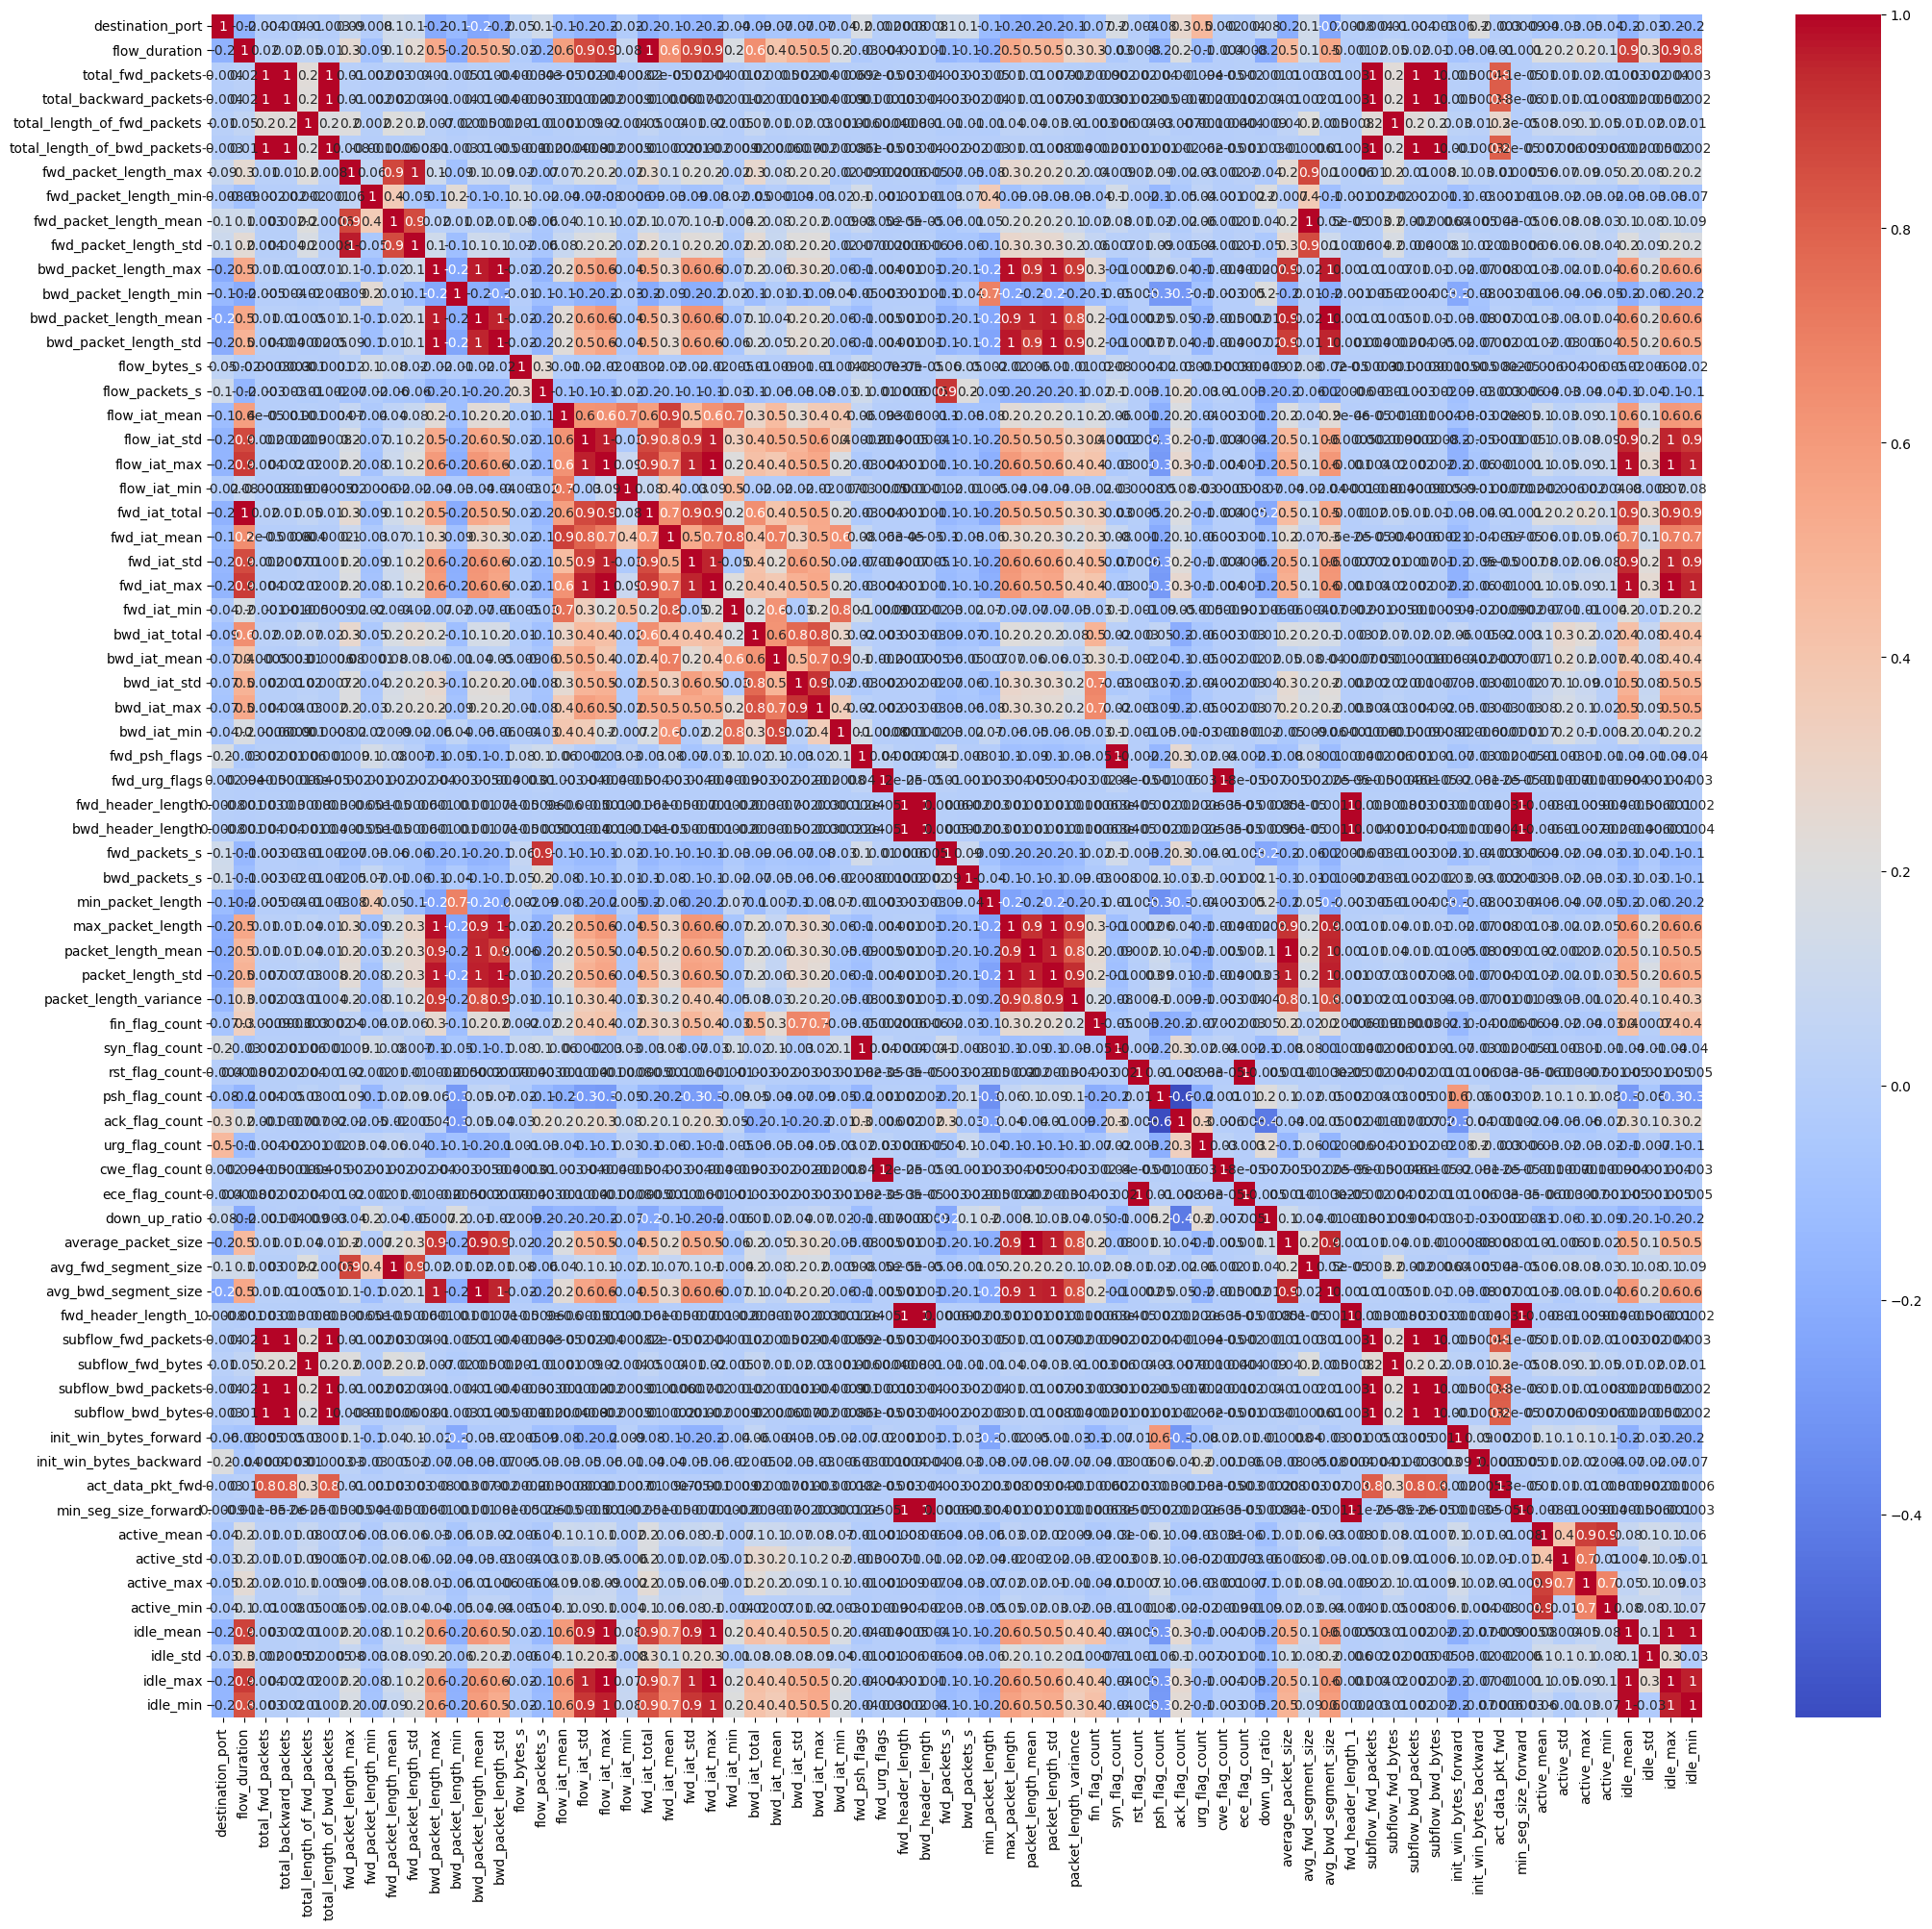

In [14]:
# Еще раз посмотрим на карту
plt.figure(figsize= (25, 23))
sns.heatmap(df_filtred.corr(),cmap= 'coolwarm', fmt=".1g", annot=True)
plt.show()

Достаточно много признаков в с высокой корреляцией. Можно сократить данные, оставив , например, только средние значения признаков, а max, min, std удалить. Также не совсем понятны значения "idle", возможно их тоже стоит удалить.


Напомним, что единственный категориальный признак- это Label. Далее для простоты подбора определенных признаков, нужно скопировать датасет( в каждом датафрейме отдельный набор признаков для обучения модели). Чтобы не проводить кодировку несколько раз, сделаем ее сейчас на едином датасете.

In [9]:
# Скопируем нашу отфильтрованную таблицу
data = df_filtred.copy()

# Проведем кодирование
labelencoder = LabelEncoder()
data['label'] = labelencoder.fit_transform(data['label'])


df_value_1=data['label'].value_counts()
print(df_value_1)

0     240000
4     115974
10     79660
2      64366
3      10293
7       7938
11      5897
6       5796
5       5499
1       1966
12      1507
14       652
9         36
13        21
8         11
Name: label, dtype: int64


In [10]:
# Поменяем размерность
data['label']=data['label'].astype('int32')

data['label'].dtype

dtype('int32')

На безобасную атаку был присвоен класс 0. Все остальные классы будут считаться опасными.

Теперь можно наш датаст разделить: одна таблица будет без высококоррелирующих признаков, другая будет некоторые таке признаки. Возможно, потом набор таких признаков поменяется.

In [11]:
# Создадим отдельный датасет, где уберем, на наш взгляд, все неподходящие признаки
# data_filtred_total будет со всеми удаленными признаками с высокой корреляцией

data_filtred=data.drop(columns=['fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min'])

data_filtred_total=data_filtred.drop(columns=['min_packet_length','max_packet_length', 'packet_length_std', 'packet_length_variance',
       'idle_std', 'idle_max', 'idle_min', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_std', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'active_std', 'active_max', 'active_min'])

## 2. Baseline
Испытаем модель машинного обучения на сырых данных. Возьмем модель RandomForest, чтобы не пришлось сильно нагружать тетрадь. Сейчас разделим датафрейм на выборки в соотношении 3:1

In [12]:
# делим на выборки, за целевой признак берем 'Label'

X=data.drop('label', axis=1)
y=data[['label']]

X_train,X_test, y_train,y_test= train_test_split(X, y, test_size=0.25, random_state=12345)

print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (404712, 70)
Размер тестовой выборки: (134904, 70)


In [13]:
%%time
model_clf = RandomForestClassifier(random_state=12345)

model_clf.fit(X_train, y_train)
target_pred = model_clf.predict(X_test)

# Оценим метрики качества модели с помощью classification_report
report = classification_report(y_test, target_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59994
           1       0.96      0.94      0.95       493
           2       1.00      1.00      1.00     16084
           3       1.00      1.00      1.00      2543
           4       1.00      1.00      1.00     29004
           5       1.00      0.99      0.99      1294
           6       1.00      0.99      1.00      1498
           7       1.00      1.00      1.00      1972
           8       1.00      1.00      1.00         2
           9       1.00      0.60      0.75         5
          10       1.00      1.00      1.00     20027
          11       1.00      1.00      1.00      1447
          12       0.75      0.81      0.78       378
          13       1.00      0.25      0.40         4
          14       0.43      0.31      0.36       159

    accuracy                           1.00    134904
   macro avg       0.94      0.86      0.88    134904
weighted avg       1.00   

Мы получили "сырые" метрики, теперь будем пробовать подбирать параметры и "играться с признаками".

## 3. Подготовка данных для обучения

Прежде чем перейти к подбору модели, нужно провести некоторую подготовку данных. То есть, провести масштабирование данных, решить проблему дисбаланса. Посмотрим на метрику, и сли будт улучшения, то оставим наши преобразования. Если нет- будем думать дальше.

In [14]:
# Введем наши константы
RANDOM_STATE=12345
cv=5


In [15]:
#Разделим на выборки наши данные с меньшим кол-ом признаков

X_f_t=data_filtred_total.drop('label', axis=1)
y_f_t=data_filtred_total[['label']]

X_train,X_test, y_train,y_test= train_test_split(X_f_t, y_f_t, test_size=0.25, random_state=RANDOM_STATE)

print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (404712, 44)
Размер тестовой выборки: (134904, 44)


In [16]:
# Теперь проведем масштабирование
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (404712, 44)
Размер тестовой выборки: (134904, 44)


## 4. Обучение моделей
Возьмем стандартный набор моделей, это линейные модели Дерево решений, Случайный лес и Логистическая регрессия. Также возьмем модели бустингов.

In [23]:
#%%time
#  DecisionTreeClassifier
#params_tree =  {'max_depth': [1,5,10]}#, 'min_samples_leaf': [1,8],'min_samples_split':[2,5,10]}

#score_dt = grid(DecisionTreeClassifier(random_state=RANDOM_STATE), params_tree)


    precision    recall  f1-score   support

           0       1.00      0.89      0.94     59994
           1       0.52      1.00      0.69       493
           2       1.00      1.00      1.00     16084
           3       0.70      0.93      0.80      2543
           4       0.95      0.93      0.94     29004
           5       0.29      0.87      0.44      1294
           6       0.21      0.75      0.32      1498
           7       1.00      1.00      1.00      1972
           8       1.00      0.50      0.67         2
           9       0.83      1.00      0.91         5
          10       1.00      0.94      0.97     20027
          11       1.00      1.00      1.00      1447
          12       0.51      0.37      0.43       378
          13       0.01      0.75      0.02         4
          14       0.20      0.86      0.33       159

    accuracy                           0.92    134904
    macro avg       0.68      0.85     0.70    134904
    weighted avg    0.96      0.92     0.94    134904

CPU times: user 52.7 s, sys: 1.38 s, total: 54.1 s
Wall time: 5min 20s

In [24]:
%%time
#  LogisticRegression
#params_lg = {'multi_class': ['ovr', 'multinomial']} # 'multi_class': range('ovr', 'multinomial')

#score = grid(LogisticRegression(random_state=RANDOM_STATE), params_lg)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


       precision    recall  f1-score   support

           0       0.66      0.41      0.50     59994
           1       0.05      0.77      0.09       493
           2       0.42      0.46      0.43     16084
           3       0.37      0.80      0.51      2543
           4       0.91      0.88      0.89     29004
           5       0.28      0.66      0.39      1294
           6       0.17      0.49      0.26      1498
           7       0.23      0.68      0.34      1972
           8       0.20      0.50      0.29         2
           9       0.00      0.40      0.00         5
          10       0.85      0.68      0.76     20027
          11       0.84      0.98      0.91      1447
          12       0.00      0.00      0.00       378
          13       0.00      0.25      0.00         4
          14       0.07      0.96      0.14       159

    accuracy                            0.58    134904
    macro avg       0.34      0.59      0.37    134904
    weighted avg    0.69      0.58      0.61    134904

CPU times: user 13min 47s, sys: 2min 46s, total: 16min 34s
Wall time: 37min

Метрика не впечатляет, большой объем данных не дает быстро обучить модели.

In [25]:
# Создадим функцию, которая будет обучать модель на лучших гиперпараметрах
def grid_s(model, params):
    grid_s = RandomizedSearchCV(model,
    param_distributions=params,
    n_jobs=-1, cv=5)
    grid_s.fit(X_train, y_train)
    report=classification_report(y_test,grid_s.best_estimator_.predict(X_test))
    print(report)
    return report

In [26]:
#%%time
#  DecisionTreeClassifier
#params_tree =  {'max_depth': [1,5,10], 'min_samples_leaf': [1,8],'min_samples_split':[2,10]}

#score_dt = grid_s(DecisionTreeClassifier(random_state=RANDOM_STATE), params_tree)


             precision    recall  f1-score   support

           0       0.99      0.99      0.99     59994
           1       0.83      0.58      0.68       493
           2       1.00      1.00      1.00     16084
           3       0.90      0.98      0.94      2543
           4       0.99      1.00      0.99     29004
           5       0.98      0.90      0.94      1294
           6       0.84      0.91      0.87      1498
           7       1.00      1.00      1.00      1972
           8       1.00      1.00      1.00         2
           9       1.00      0.20      0.33         5
          10       1.00      1.00      1.00     20027
          11       1.00      1.00      1.00      1447
          12       0.51      0.84      0.63       378
          13       0.00      0.00      0.00         4
          14       0.80      0.03      0.05       159

    accuracy                           0.99    134904
    macro avg       0.86      0.76      0.76    134904
    weighted avg       0.99      0.99      0.99    134904

CPU times: user 7.55 s, sys: 401 ms, total: 7.95 s
Wall time: 2min 22s


     Предыдущие метрики для DecisionTreeClassifier       
          
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     59994
           1       0.52      1.00      0.69       493
           2       1.00      1.00      1.00     16084
           3       0.70      0.93      0.80      2543
           4       0.95      0.93      0.94     29004
           5       0.29      0.87      0.44      1294
           6       0.21      0.75      0.32      1498
           7       1.00      1.00      1.00      1972
           8       1.00      0.50      0.67         2
           9       0.83      1.00      0.91         5
          10       1.00      0.94      0.97     20027
          11       1.00      1.00      1.00      1447
          12       0.51      0.37      0.43       378
          13       0.01      0.75      0.02         4
          14       0.20      0.86      0.33       159

    accuracy                           0.92      134904
    macro avg       0.68     0.85      0.70      134904
    weighted avg    0.96     0.92      0.94      134904



При сравнении видно, что метрики при балансировке намного ниже, чем без нее.

In [27]:
%%time
##  LogisticRegression
#params_lg = {'multi_class': ['ovr', 'multinomial']}

#score = grid_s(LogisticRegression(random_state=RANDOM_STATE), params_lg)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


             precision    recall  f1-score   support

           0       0.95      0.93      0.94     59994
           1       0.48      0.02      0.04       493
           2       0.84      1.00      0.91     16084
           3       0.91      0.86      0.88      2543
           4       0.94      0.93      0.93     29004
           5       0.91      0.81      0.86      1294
           6       0.89      0.81      0.85      1498
           7       0.86      0.98      0.92      1972
           8       0.67      1.00      0.80         2
           9       0.22      0.40      0.29         5
          10       0.95      1.00      0.97     20027
          11       0.57      0.15      0.23      1447
          12       0.89      0.04      0.08       378
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00       159

    accuracy                           0.93    134904
    macro avg       0.67      0.59      0.58    134904
    weighted avg       0.92      0.93      0.92    134904

CPU times: user 27 s, sys: 3.38 s, total: 30.4 s
Wall time: 5min 55s

   Предыдущие метрики LogisticRegression

             precision    recall  f1-score   support

           0       0.66      0.41      0.50     59994
           1       0.05      0.77      0.09       493
           2       0.42      0.46      0.43     16084
           3       0.37      0.80      0.51      2543
           4       0.91      0.88      0.89     29004
           5       0.28      0.66      0.39      1294
           6       0.17      0.49      0.26      1498
           7       0.23      0.68      0.34      1972
           8       0.20      0.50      0.29         2
           9       0.00      0.40      0.00         5
          10       0.85      0.68      0.76     20027
          11       0.84      0.98      0.91      1447
          12       0.00      0.00      0.00       378
          13       0.00      0.25      0.00         4
          14       0.07      0.96      0.14       159

    accuracy                            0.58    134904
    macro avg       0.34      0.59      0.37    134904
    weighted avg    0.69      0.58      0.61    134904



   Аналогичная ситуация и с LogisticRegression. Метрики при дисбалансе намного лучше, чем с балансировкой.


In [28]:
%%time
# Random Forest
#params_rf =  {'n_estimators': [10, 50, 100],
#           'max_depth': [1,8],
#           'min_samples_leaf': [1, 2, 5],
#           'min_samples_split': [1, 2, 5]}

#score_rf = grid_s(RandomForestClassifier(random_state=RANDOM_STATE), params_rf)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


Модели бустинга обучались достаточно долго, поэтому пока обойдемся без них. Попробуем обучить модели на менее очищенных данных

In [29]:
#Разделим на выборки наши данные

X_f=data_filtred.drop('label', axis=1)
y_f=data_filtred[['label']]

X_train_f,X_test_f, y_train_f,y_test_f= train_test_split(X_f, y_f, test_size=0.25, random_state=RANDOM_STATE)

print('Размер обучающей выборки:', X_train_f.shape, y_train_f.shape)
print('Размер тестовой выборки:', X_test_f.shape)

Размер обучающей выборки: (404712, 63) (404712, 1)
Размер тестовой выборки: (134904, 63)


Сейчас попробуем не проводить никаких видоизменений, то есть не будем делать масштабирование, самплинги и так далее. Посмотрим, будет ли разница.

In [30]:
# Создадим функцию, которая будет обучать модель на лучших гиперпараметрах
def grid_f(model, params):
    grid_f = RandomizedSearchCV(model,
    param_distributions=params,
    n_jobs=-1, cv=5)
    grid_f.fit(X_train_f, y_train_f)
    report=classification_report(y_test_f,grid_f.best_estimator_.predict(X_test_f))
    print(report)
    return report

In [31]:
%%time
#  DecisionTreeClassifier
#params_tree =  {'max_depth': [1,5,10]}#, 'min_samples_leaf': [1,8],'min_samples_split':[2,5,10]}

#score_dt = grid_f(DecisionTreeClassifier(random_state=RANDOM_STATE), params_tree)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


              precision    recall  f1-score   support

           0       0.98      0.99      0.99     59994
           1       0.87      0.24      0.37       493
           2       1.00      1.00      1.00     16084
           3       1.00      0.93      0.96      2543
           4       0.99      1.00      0.99     29004
           5       0.99      0.86      0.92      1294
           6       0.90      0.90      0.90      1498
           7       1.00      1.00      1.00      1972
           8       1.00      1.00      1.00         2
           9       0.00      0.00      0.00         5
          10       1.00      1.00      1.00     20027
          11       1.00      1.00      1.00      1447
          12       0.63      0.83      0.72       378
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00       159

    accuracy                           0.99    134904
    macro avg       0.76      0.72      0.72    134904
    weighted avg       0.99      0.99      0.99    134904

    CPU times: user 11 s, sys: 262 ms, total: 11.2 s
    Wall time: 1min 10s

  Предыдущие показания DecisionTreeClassifier
    
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     59994
           1       0.83      0.58      0.68       493
           2       1.00      1.00      1.00     16084
           3       0.90      0.98      0.94      2543
           4       0.99      1.00      0.99     29004
           5       0.98      0.90      0.94      1294
           6       0.84      0.91      0.87      1498
           7       1.00      1.00      1.00      1972
           8       1.00      1.00      1.00         2
           9       1.00      0.20      0.33         5
          10       1.00      1.00      1.00     20027
          11       1.00      1.00      1.00      1447
          12       0.51      0.84      0.63       378
          13       0.00      0.00      0.00         4
          14       0.80      0.03      0.05       159

    accuracy                            0.99    134904
    macro avg       0.86      0.76      0.76    134904
    weighted avg    0.99      0.99      0.99    134904

    CPU times: user 7.55 s, sys: 401 ms, total: 7.95 s
    Wall time: 2min 22s

Где-то метрика улучшилась, где-то нет, наводит на мысли, то возможно придется каждый класс отдельно прорабатывать...


In [32]:
%%time
# Random Forest
#params_rf =  {'n_estimators': [10, 50, 100],
#           'max_depth': [1,8],
#           'min_samples_leaf': [1, 2, 5],
#           'min_samples_split': [1, 2, 5]}

#score_rf = grid_f(RandomForestClassifier(random_state=RANDOM_STATE), params_rf)


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     59994
           1       0.88      0.26      0.40       493
           2       1.00      1.00      1.00     16084
           3       1.00      0.92      0.96      2543
           4       0.99      1.00      1.00     29004
           5       0.99      0.94      0.97      1294
           6       1.00      0.94      0.97      1498
           7       1.00      1.00      1.00      1972
           8       1.00      0.50      0.67         2
           9       0.00      0.00      0.00         5
          10       1.00      1.00      1.00     20027
          11       1.00      0.97      0.99      1447
          12       0.00      0.00      0.00       378
          13       0.00      0.00      0.00         4
          14       1.00      0.01      0.02       159

    accuracy                           0.99    134904
    macro avg       0.79      0.64      0.66    134904
    weighted avg    0.98      0.99      0.98    134904

    CPU times: user 48.5 s, sys: 1.56 s, total: 50.1 s
    Wall time: 14min 25s

Предыдущие показания RandomForestClassifier

             precision    recall  f1-score   support

           0       0.98      1.00      0.99     59994
           1       0.88      0.26      0.40       493
           2       1.00      1.00      1.00     16084
           3       0.98      0.96      0.97      2543
           4       0.99      1.00      1.00     29004
           5       0.99      0.93      0.96      1294
           6       0.99      0.93      0.96      1498
           7       1.00      1.00      1.00      1972
           8       1.00      0.50      0.67         2
           9       0.00      0.00      0.00         5
          10       1.00      1.00      1.00     20027
          11       1.00      0.98      0.99      1447
          12       1.00      0.04      0.08       378
          13       0.00      0.00      0.00         4
          14       1.00      0.02      0.04       159

    accuracy                            0.99    134904
    macro avg       0.85      0.64      0.67    134904
    weighted avg    0.99      0.99      0.99    134904

    CPU times: user 37.8 s, sys: 1.15 s, total: 38.9 s
    Wall time: 11min 4s


Метрика не сильно лучше, хотя на более больших данных, она должна была предсказывать с более высокой точностью.

Попробуем реализовать план с отдельной настройкой классов. Возьмем данные с меньшим кол-ом признаков, и попробуем удалить еще несколько. затем будем настраивать классы с наименьшим кол-вом, увеличив кол-во показателей. А класс "0" наоборот попытаемся уменьшить. Таким образом,уйдет некоторый дисбаланс.

In [17]:

# Используем метод "соседей" для уменьшения выборки
from  imblearn.under_sampling import NeighbourhoodCleaningRule

ncr = NeighbourhoodCleaningRule()
X_res, y_res = ncr.fit_resample(X_train, y_train)


In [18]:
y_res.value_counts()

label
0        177655
4         86802
10        59429
2         48233
3          7718
7          5952
11         4418
6          4259
5          4183
1          1295
12          669
14          117
9            17
8             9
13            3
dtype: int64

Попробуем обучить модели на уменьшенной выборке

In [22]:
# Создадим функцию, которая будет обучать модель на лучших гиперпараметрах
def grid_u(model, params):
    grid_u = RandomizedSearchCV(model,
    param_distributions=params,
    n_jobs=-1, cv=5)
    grid_u.fit(X_res, y_res)
    print(grid_u.best_estimator_)
    return grid_u.best_estimator_


In [23]:
%%time
#DecisionTreeClassifier
params_tree =  {'max_depth': range(5,40,3)}#, 'min_samples_leaf': [1,8],'min_samples_split':[2,5,10]}

score_dt = grid_u(DecisionTreeClassifier(random_state=RANDOM_STATE), params_tree)


DecisionTreeClassifier(max_depth=38, random_state=12345)
CPU times: user 10.8 s, sys: 533 ms, total: 11.4 s
Wall time: 3min 50s


In [25]:
report=classification_report(y_test,score_dt.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59994
           1       0.95      0.94      0.95       493
           2       1.00      1.00      1.00     16084
           3       1.00      1.00      1.00      2543
           4       1.00      1.00      1.00     29004
           5       0.99      0.99      0.99      1294
           6       1.00      0.99      0.99      1498
           7       1.00      1.00      1.00      1972
           8       1.00      1.00      1.00         2
           9       0.67      0.40      0.50         5
          10       1.00      1.00      1.00     20027
          11       1.00      1.00      1.00      1447
          12       0.61      0.72      0.66       378
          13       1.00      0.25      0.40         4
          14       0.37      0.22      0.28       159

    accuracy                           1.00    134904
   macro avg       0.91      0.83      0.85    134904
weighted avg       1.00   

Предыдущие значения DecisionTreeClassifier

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     59994
           1       0.87      0.24      0.37       493
           2       1.00      1.00      1.00     16084
           3       1.00      0.93      0.96      2543
           4       0.99      1.00      0.99     29004
           5       0.99      0.86      0.92      1294
           6       0.90      0.90      0.90      1498
           7       1.00      1.00      1.00      1972
           8       1.00      1.00      1.00         2
           9       0.00      0.00      0.00         5
          10       1.00      1.00      1.00     20027
          11       1.00      1.00      1.00      1447
          12       0.63      0.83      0.72       378
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00       159

    accuracy                           0.99    134904
    macro avg       0.76      0.72      0.72    134904
    weighted avg    0.99      0.99      0.99    134904

    CPU times: user 11 s, sys: 262 ms, total: 11.2 s
    Wall time: 1min 10s

In [37]:
%%time
# Random Forest
#params_rf =  {'n_estimators': [10, 50, 100],
#           'max_depth': [1,8],
#           'min_samples_leaf': [1, 2, 5],
#           'min_samples_split': [1, 2, 5]}

#score_rf = grid_u(RandomForestClassifier(random_state=RANDOM_STATE), params_rf)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     59994
           1       0.88      0.26      0.40       493
           2       1.00      1.00      1.00     16084
           3       0.99      0.96      0.97      2543
           4       0.99      1.00      1.00     29004
           5       0.99      0.93      0.95      1294
           6       1.00      0.93      0.96      1498
           7       1.00      1.00      1.00      1972
           8       1.00      0.50      0.67         2
           9       0.00      0.00      0.00         5
          10       1.00      1.00      1.00     20027
          11       1.00      0.98      0.99      1447
          12       1.00      0.04      0.08       378
          13       0.00      0.00      0.00         4
          14       1.00      0.03      0.05       159

    accuracy                           0.99    134904
    macro avg       0.85      0.64      0.67    134904
    weighted avg       0.99      0.99      0.99    134904

    CPU times: user 45.5 s, sys: 1.9 s, total: 47.4 s
    Wall time: 14min 43s

Как мывидим, лучшие результаты показала модель Дерево Решений. Но по сравнению с нашей базовой моделькой, эти результаты хуже.

Напоследок посмотрим важность признаков

In [26]:
# Выделим лучшую модель
best_model=DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=38)
best_model.fit(X_res, y_res)
pred=best_model.predict(X_test)

report=classification_report(y_test,pred)
print(report)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59994
           1       0.95      0.94      0.95       493
           2       1.00      1.00      1.00     16084
           3       1.00      1.00      1.00      2543
           4       1.00      1.00      1.00     29004
           5       0.99      0.99      0.99      1294
           6       1.00      0.99      0.99      1498
           7       1.00      1.00      1.00      1972
           8       1.00      1.00      1.00         2
           9       0.67      0.40      0.50         5
          10       1.00      1.00      1.00     20027
          11       1.00      1.00      1.00      1447
          12       0.61      0.72      0.66       378
          13       1.00      0.25      0.40         4
          14       0.37      0.22      0.28       159

    accuracy                           1.00    134904
   macro avg       0.91      0.83      0.85    134904
weighted avg       1.00   

In [ ]:
!pip install shap

In [ ]:
import shap

PermutationExplainer explainer: 134905it [41:19, 54.31it/s]                            


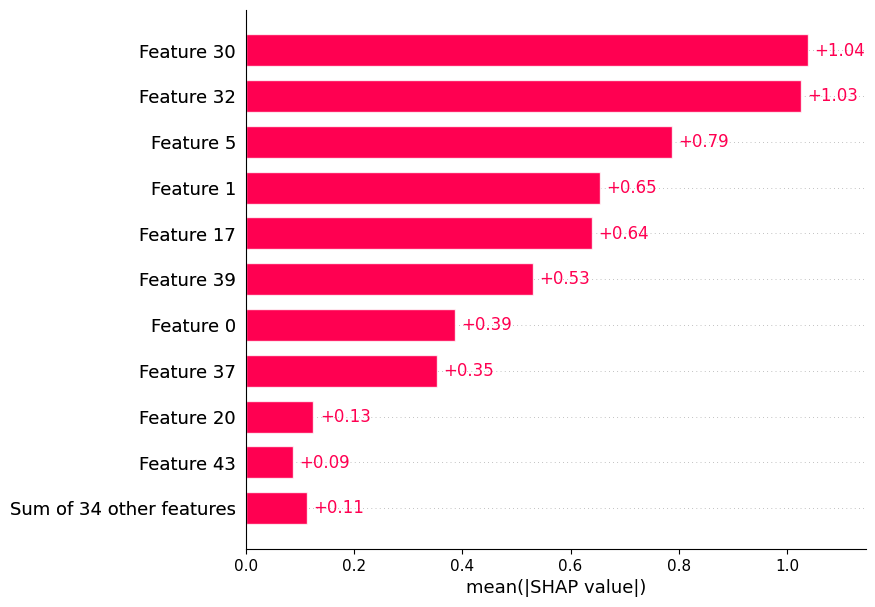

In [ ]:
# Посмотрим на важность признаков
def explain_features(best_models, features_train, features_test):
    explainer = shap.explainers.Permutation(best_models.predict, features_train)
    shap_values = explainer(features_test)

    shap.plots.bar(shap_values, max_display=11)

    plt.show()


explain_features(best_model,#X_train, X_test)
                 pd.DataFrame(X_res, columns=X.columns),
                 pd.DataFrame(X_test, columns=X.columns)) #не хочет работать такой вариант кода

Скопируем наши признаки на всякий случай

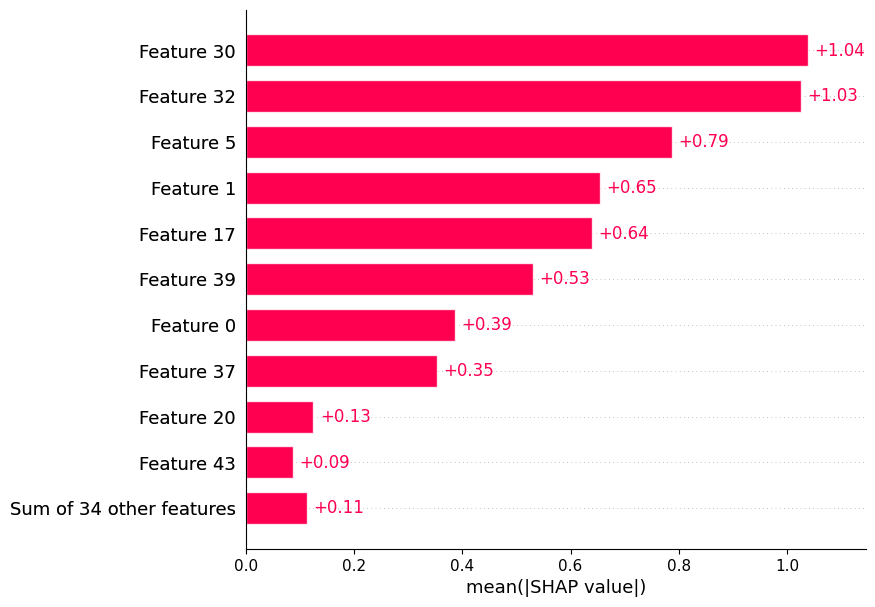

## ИТОГ


Модель обучена, по метрике нам больше по душе Дерево решений. К сожалению, высокой метрики нам добиться не вышло, но в то же время она не на столько низкая.

## Docker

In [27]:
# Сохраним модель
import joblib
joblib.dump(best_model,'net_traffic_model.joblibdump')

# Проверим выгрузку
model_load = joblib.load('net_traffic_model.joblibdump')
print(model_load)

DecisionTreeClassifier(max_depth=38, random_state=12345)


## Комментарии для ревью


Был еще вариант испробовать OneVsRestClassifier и Pipeline. Код ниже. Также не хотел обучаться, больше часа. То ли данных очень много, то ли не вывозит мой агрегат)
Еще не знала, было ли уместно одни классы уменьшать, а другие увеличить, но рисковать не стала(хотела взять SMOTE для увеличения) и так много времени на обучение моделей уходило.

In [ ]:
#from imblearn.pipeline import Pipeline

# define pipeline

#pipeline_dt=Pipeline([
#    ('under', NeighbourhoodCleaningRule()),
 #                    ('model',DecisionTreeClassifier())])
#params_tree =  {'model__max_depth': [1,5,10]}#, 'min_samples_leaf': [1,8],'min_samples_split':[2,5,10]}

#rs = RandomizedSearchCV(pipeline_dt, param_distributions=params_tree, n_jobs=-1, cv=5)
#rs.fit(X_train, y_train)
#report=classification_report(y_test,rs.best_estimator_.predict(X_test))
#print(report)



In [ ]:
#from sklearn.multiclass import OneVsRestClassifier

In [ ]:
#%%time

#model_forest = OneVsRestClassifier(RandomForestClassifier(random_state=RANDOM_STATE, criterion = 'entropy'))
#словарь с гиперпараметрами и значениями, которые хотим перебрать

#parameters_forest = {'estimator__n_estimators': (300, 900, 100),
#                    'estimator__max_depth': (2, 11, 2),
#                    'estimator__min_samples_split': (2, 4),
#                    'estimator__min_samples_leaf': (1, 3)}

#будем использовать RandomizedSearchCV, он работает на много быстрее
#gs_forest = RandomizedSearchCV(model_forest, param_distributions=parameters_forest, scoring='accuracy', cv=5, n_jobs=-1)

#gs_forest.fit(X_train, y_train)

#Accuracy_forest = gs_forest.best_score_
#best_params_forest = gs_forest.best_params_
#best_model_forest = gs_forest.best_estimator_